2. Разработать программу реализующую интегрирование заданной функции методом средних прямоугольников (или иным методом, на выбор) с адаптивной сеткой. Сравнить скорость сходимости данного метода и метода с равномерной сеткой.
*Указание: для выбора "наибольшего" интервала используйте модуль `heapq` из стандартной библиотеки. (При использовании языка `C++`, используйте `std::set`).* 

https://github.com/elluscinia/smoothsort/wiki/%D0%92%D0%BE%D1%81%D1%85%D0%B2%D0%B0%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5-heapq.-%D0%9E-%D0%BA%D1%83%D1%87%D0%B0%D1%85 (спасибо Вячеславу М.)

In [1]:
import numpy as np

%matplotlib notebook

import matplotlib.pyplot as plt
import seaborn as sns #очень крутые графички
plt.xkcd()

<matplotlib.pyplot.xkcd.<locals>.dummy_ctx at 0x25bafc9ac88>

heapq.heapify(x)

Превращает список x в кучу, на месте, за линейное время.

Как раз то, что нам нужно + определим основные функции, которые будут использоваться

In [2]:
import heapq
# A rectangle is (start, width)
# A list element is (-weight, (start, width))

def make_rect(a, b, f):
    """Make a rectangle for the interval [a, b]"""
    rect = (a, b-a)
    xm = a + rect[1] / 2.
    return (f(xm) * rect[1], rect)

def get_max_elem_old(lst, key=None):
    """Find and remove the maximum element from the list.
    
    Find the max element (according to the parameter `key`, which is a callable),
    remove it from the list, and return both the element and the rest.
    """
    if key is None:
        # use the identity function
        key = lambda x: x
    
    # find the max element
    elem = max(lst, key=key) # ключ, который нужен
    
    # find its position in the list
    idx = lst.index(elem)
    
    return elem, lst[:idx] + lst[idx+1:] #([:idx] не включая концовку - Python же всё-таки!!!!

def get_max_elem(lst):
    """Find rectangular with max square by heap sort, return this element and remaining list"""
    heapq.heapify(lst)
    max_element = lst[-1]
    lst_w_t_max = lst[:-1]
    return max_element, lst_w_t_max 

def adapt_rect_list(f, a, b, npts):
    """Integrate f(x) from a to b using npts steps of the adaptive algorithm.
    """
    lst = []

    # start from a single rectangle
    item = make_rect(a, b, f)
    lst.append(item)
    
    # loop
    for _ in range(npts):
        # get the largest one
        rect, lst = get_max_elem(lst) # lst ||  убрали lambda x: -x[0], так как  мы теперь используем функцию heapq
        w, (start, width) = rect # распаковали в рект (что-то, где можно итерироваться, первый элемент записать, а второй в тупель
                
        # and split it into two halves
        c = start + width / 2.
        
        rect1 = make_rect(start, c, f)
        rect2 = make_rect(c, start + width, f)
        
        lst.append(rect1)
        lst.append(rect2)
        
    # collect the answer
    return sum(w for w, r in lst), lst #суммирую значения w в цикле, где я бегу по списку и суммирую по первому элементу



Правило *средних прямоугольников*,

$$
\int_{x_0}^{x_0 + h} f(x)\,dx \approx f(x_0 + \frac{h}{2}) \, h\;,
$$


In [3]:
def crect(f, a, b, npts):

    h = (b - a) / npts
    summ = 0
    for j in range(npts):
        x = a + h*(j + 0.5)
        summ += f(x)
    return summ * h

In [4]:
a = 0
b = 10
def f(x):
    """Интегрируемая функция"""
    f = x ** 3 #+ 1 
    return f
def exact(a,b): 
    """Вычисляет реальное значение интеграла"""
    exact = b ** 4 * 1/4 - a ** 4 * 1/4 #+ b - a
    return exact
# посмотрим, как ведёт себя алгоритм при разном количестве деления прямоугольников

for n in (5, 25, 125, 250, 500, 1000, 5000):
    res, lst = adapt_rect_list(f, a, b, n)
    print ('n, res = ', n, res, 'Normal value:', exact(a,b))


n, res =  5 2392.7927017211914 Normal value: 2500.0
n, res =  25 2420.791834592819 Normal value: 2500.0
n, res =  125 2494.249071176853 Normal value: 2500.0
n, res =  250 2494.953293121824 Normal value: 2500.0
n, res =  500 2499.5274423122983 Normal value: 2500.0
n, res =  1000 2499.652126387268 Normal value: 2500.0
n, res =  5000 2499.69105042176 Normal value: 2500.0


Окей, теперь вычислим время выполнения написанной программы

In [5]:
%timeit adapt_rect_list(f, a, b, npts=1000)

42.3 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Метод с равномерной сеткой или Правило *средних прямоугольников*,

$$
\int_{x_0}^{x_0 + h} f(x)\,dx \approx f(x_0 + \frac{h}{2}) \, h\;,
$$

является точным для линейной функции $f(x)$, поэтому погрешность составной формулы $\sim 1/N^2$.

In [6]:
def crect(f, a, b, npts):
    """Метод с равномерной сеткой или правило средних прямоугольников"""
    h = (b - a) / npts
    summ = 0
    for j in range(npts):
        x = a + h*(j + 0.5)
        summ += f(x)
    return summ * h

## Нарисуем графичек с двумя методами:
 - метода с адаптивной сеткой
 - метода с равномерной сеткой

Покажем также скорость сходимости данного метода и метода с равномерной сеткой (разница между точным значением и при разных n посмотрим, как ведут себя алгоритмы) 

In [7]:
lst_n = [i for i in range(1000) if (i!=0 and i % 25 == 0)]
lst_adapt = []
lst_n_adapt = []
for n in lst_n:
    res, lst = adapt_rect_list(f, 0, 10, n) 
    lst_adapt.append (abs(res - exact (0,10)))
    lst_n_adapt.append (abs(crect(f, 0, 10, n)- exact (0,10)))
# sns.set(style="darkgrid")
# sns.lineplot(x=n, y=lst_adapt) Anaconda не успела обновиться ещё, жалко ;(

<IPython.core.display.Javascript object>


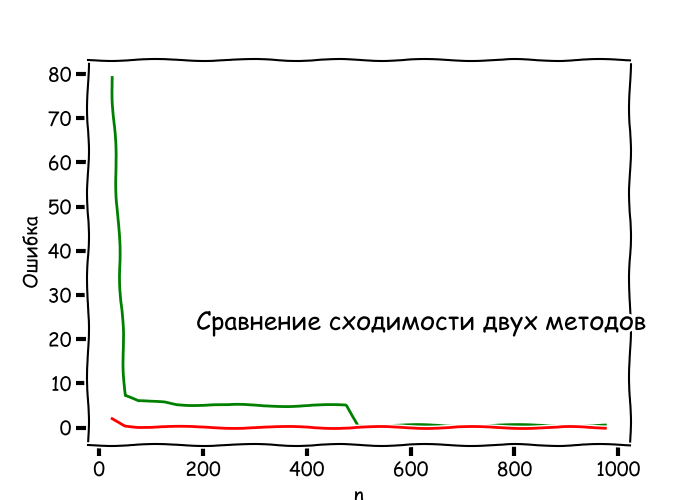

Text(0.5,0,'n')

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(lst_n, lst_adapt, color='g',label = 'адаптивный')
ax1.plot(lst_n, lst_n_adapt, color='r',label = 'постоянный')
ax1.text(0.2, 0.3, 'Сравнение сходимости двух методов', transform=ax1.transAxes, fontsize=18)
plt.ylabel('Ошибка')
plt.xlabel('n')

## Получаем, что метод с постоянной сеткой работает лучше в данном случае. 
Сделаем всё тоже самое для функции, которая будет иметь резкие пики.